In [2]:
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Bidirectional, SpatialDropout1D


In [3]:
# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moneykicks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load data from CSV file
df = pd.read_csv('200kReviewWithSentimentFlipkart.csv')

# Keep only 'Summary' and 'Stance' columns
df = df[['Summary', 'Stance']]

# Drop rows where 'Summary' or 'Stance' is NaN
df = df.dropna(subset=['Summary', 'Stance'])

# Ensure all entries in 'Summary' are strings
df['Summary'] = df['Summary'].astype(str)

# for full review display without truncation
pd.set_option('display.max_colwidth', None)

# Print value counts of 'Stance' column
print(df['Stance'].value_counts())

Stance
supportive    166575
oppose         28232
neutral        10234
Name: count, dtype: int64


In [5]:
# Preprocess the text data
stop_words = list(stopwords.words('english'))
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.7)

# Transform the text data into TF-IDF features
X = tfidf.fit_transform(df['Summary'])

# Encode the target labels
y = df['Stance']

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict the stances on the test set using Naive Bayes
nb_y_pred = nb_model.predict(X_test)

# Evaluate the Naive Bayes model
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred)
print("Naive Bayes Results:")
print(f"Accuracy: {nb_accuracy}")
print("Classification Report:")
print(nb_report)

Naive Bayes Results:
Accuracy: 0.8753200516959692
Classification Report:
              precision    recall  f1-score   support

     neutral       0.94      0.06      0.11      2095
      oppose       0.86      0.49      0.62      5566
  supportive       0.88      0.99      0.93     33348

    accuracy                           0.88     41009
   macro avg       0.89      0.51      0.55     41009
weighted avg       0.88      0.88      0.85     41009



In [7]:
from sklearn.preprocessing import LabelEncoder 
# Assuming y_train contains the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
import numpy as np
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [9]:
# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear', class_weight=class_weights_dict)
svm_model.fit(X_train, y_train_encoded)

# Predict the stances on the test set using SVM
svm_y_pred_encoded = svm_model.predict(X_test)

# Decode the predicted labels back to the original class names
svm_y_pred = label_encoder.inverse_transform(svm_y_pred_encoded)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_report = classification_report(y_test, svm_y_pred)
print("SVM Results:")
print(f"Accuracy: {svm_accuracy}")
print("Classification Report:")
print(svm_report)

SVM Results:
Accuracy: 0.850618156989929
Classification Report:
              precision    recall  f1-score   support

     neutral       0.31      0.68      0.43      2095
      oppose       0.67      0.76      0.72      5566
  supportive       0.97      0.88      0.92     33348

    accuracy                           0.85     41009
   macro avg       0.65      0.77      0.69     41009
weighted avg       0.90      0.85      0.87     41009



In [10]:
# Assuming y_train contains the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {label: weight for label, weight in zip(label_encoder.classes_, class_weights)}

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train_encoded)

# Predict the stances on the test set using Random Forest
rf_y_pred_encoded = rf_model.predict(X_test)

# Decode the predicted labels back to the original class names
rf_y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred)
print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy}")
print("Classification Report:")
print(rf_report)


Random Forest Results:
Accuracy: 0.9082884244921846
Classification Report:
              precision    recall  f1-score   support

     neutral       0.55      0.55      0.55      2095
      oppose       0.81      0.72      0.76      5566
  supportive       0.94      0.96      0.95     33348

    accuracy                           0.91     41009
   macro avg       0.77      0.74      0.76     41009
weighted avg       0.91      0.91      0.91     41009



In [11]:
# Initialize the accuracy_scores dictionary
accuracy_scores = {}

# Add Naive, SVM and Random Forest accuracy scores to the comparison
accuracy_scores['Naive'] = nb_accuracy
accuracy_scores['SVM'] = svm_accuracy
accuracy_scores['Random Forest'] = rf_accuracy

best_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nThe best model based on accuracy is: {best_model} with accuracy {accuracy_scores[best_model]}")



The best model based on accuracy is: Random Forest with accuracy 0.9082884244921846


In [12]:
# Tokenizer and padding for deep learning models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Summary'])
X_seq = tokenizer.texts_to_sequences(df['Summary'])
X_pad = pad_sequences(X_seq, maxlen=100)


In [13]:
# Encode the target labels for deep learning models
y_encoded = pd.get_dummies(df['Stance']).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

In [14]:
# Compute class weights for deep learning models
class_weights_dl = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dl_dict = {i: weight for i, weight in enumerate(class_weights_dl)}

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for deep learning models
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dl = {i: class_weights[i] for i in range(len(class_weights))}

# CNN Model
cnn_model = Sequential()
cnn_model.add(Embedding(5000, 128, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dl, verbose=2)

cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred_labels = cnn_y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

cnn_accuracy = accuracy_score(y_test_labels, cnn_y_pred_labels)
cnn_report = classification_report(y_test_labels, cnn_y_pred_labels)

print("CNN Results:")
print(f"Accuracy: {cnn_accuracy}")
print("Classification Report:")
print(cnn_report)


Epoch 1/5


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2563/2563 - 55s - 22ms/step - accuracy: 0.8782 - loss: 0.4144 - val_accuracy: 0.8978 - val_loss: 0.2666
Epoch 2/5
2563/2563 - 55s - 21ms/step - accuracy: 0.9035 - loss: 0.3269 - val_accuracy: 0.8788 - val_loss: 0.3274
Epoch 3/5
2563/2563 - 55s - 22ms/step - accuracy: 0.9167 - loss: 0.2753 - val_accuracy: 0.9025 - val_loss: 0.2703
Epoch 4/5
2563/2563 - 53s - 21ms/step - accuracy: 0.9299 - loss: 0.2311 - val_accuracy: 0.9021 - val_loss: 0.2895
Epoch 5/5
2563/2563 - 55s - 22ms/step - accuracy: 0.9407 - loss: 0.2001 - val_accuracy: 0.9126 - val_loss: 0.2926
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
CNN Results:
Accuracy: 0.9126045502206833
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.72      0.51      2095
           1       0.84      0.88      0.86      5566
           2       0.99      0.93      0.96     33348

    accuracy                           0.91     41009
   macro avg       0.74      0.84      0.78     41009
weight

In [16]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(5000, 128, input_length=100))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dl, verbose=2)

lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_labels = lstm_y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

lstm_accuracy = accuracy_score(y_test_labels, lstm_y_pred_labels)
lstm_report = classification_report(y_test_labels, lstm_y_pred_labels)

print("LSTM Results:")
print(f"Accuracy: {lstm_accuracy}")
print("Classification Report:")
print(lstm_report)

Epoch 1/5


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2563/2563 - 169s - 66ms/step - accuracy: 0.8772 - loss: 0.4522 - val_accuracy: 0.8989 - val_loss: 0.2844
Epoch 2/5
2563/2563 - 162s - 63ms/step - accuracy: 0.8956 - loss: 0.3605 - val_accuracy: 0.8966 - val_loss: 0.2604
Epoch 3/5
2563/2563 - 162s - 63ms/step - accuracy: 0.9002 - loss: 0.3290 - val_accuracy: 0.9014 - val_loss: 0.2559
Epoch 4/5
2563/2563 - 162s - 63ms/step - accuracy: 0.9059 - loss: 0.3097 - val_accuracy: 0.8831 - val_loss: 0.3065
Epoch 5/5
2563/2563 - 163s - 64ms/step - accuracy: 0.9113 - loss: 0.2899 - val_accuracy: 0.9007 - val_loss: 0.2602
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step
LSTM Results:
Accuracy: 0.9007291082445317
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.77      0.47      2095
           1       0.88      0.87      0.87      5566
           2       0.99      0.91      0.95     33348

    accuracy                           0.90     41009
   macro avg       0.74      0.85      0.77     4100

In [17]:
# BiLSTM Model
bilstm_model = Sequential()
bilstm_model.add(Embedding(5000, 128, input_length=100))
bilstm_model.add(SpatialDropout1D(0.2))
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(3, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dl, verbose=2)

bilstm_y_pred = bilstm_model.predict(X_test)
bilstm_y_pred_labels = bilstm_y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

bilstm_accuracy = accuracy_score(y_test_labels, bilstm_y_pred_labels)
bilstm_report = classification_report(y_test_labels, bilstm_y_pred_labels)

print("BiLSTM Results:")
print(f"Accuracy: {bilstm_accuracy}")
print("Classification Report:")
print(bilstm_report)

Epoch 1/5


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2563/2563 - 254s - 99ms/step - accuracy: 0.8682 - loss: 0.4518 - val_accuracy: 0.8894 - val_loss: 0.2809
Epoch 2/5
2563/2563 - 248s - 97ms/step - accuracy: 0.8936 - loss: 0.3557 - val_accuracy: 0.8888 - val_loss: 0.2797
Epoch 3/5
2563/2563 - 249s - 97ms/step - accuracy: 0.9000 - loss: 0.3270 - val_accuracy: 0.8905 - val_loss: 0.2843
Epoch 4/5
2563/2563 - 249s - 97ms/step - accuracy: 0.9073 - loss: 0.3052 - val_accuracy: 0.9142 - val_loss: 0.2347
Epoch 5/5
2563/2563 - 247s - 96ms/step - accuracy: 0.9119 - loss: 0.2883 - val_accuracy: 0.8911 - val_loss: 0.3019
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step
BiLSTM Results:
Accuracy: 0.8911458460337974
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.78      0.45      2095
           1       0.87      0.88      0.87      5566
           2       0.99      0.90      0.94     33348

    accuracy                           0.89     41009
   macro avg       0.73      0.85      0.76     41

In [18]:
# Compare the accuracy of all models
accuracy_scores_all = {
    'Naive Bayes': nb_accuracy,
    'SVM': svm_accuracy,
    'Random Forest': rf_accuracy,
    'CNN': cnn_accuracy,
    'LSTM': lstm_accuracy,
    'BiLSTM': bilstm_accuracy
}

In [19]:
# Find the best model among all based on accuracy
best_model = max(accuracy_scores_all, key=accuracy_scores_all.get)
print(f"\nThe best model based on accuracy is: {best_model} with accuracy {accuracy_scores_all[best_model]}")


The best model based on accuracy is: CNN with accuracy 0.9126045502206833


In [23]:
# Function to detect stance of an input review
def predict_stance(review):
    # Preprocess the input review
    review_tfidf = tfidf.transform([review])
    
    # Use the best model to predict the stance
    if best_model == 'Naive Bayes':
        prediction = nb_model.predict(review_tfidf)
    elif best_model == 'SVM':
        prediction_encoded = svm_model.predict(review_tfidf)
        prediction = label_encoder.inverse_transform(prediction_encoded)
    elif best_model == 'Random Forest':
        prediction_encoded = rf_model.predict(review_tfidf)
        prediction = label_encoder.inverse_transform(prediction_encoded)
    elif best_model == 'CNN':
        review_seq = tokenizer.texts_to_sequences([review])
        review_pad = pad_sequences(review_seq, maxlen=100)
        prediction_probs = cnn_model.predict(review_pad)
        prediction = [np.argmax(prediction_probs)]
        prediction = label_encoder.inverse_transform(prediction)
    elif best_model == 'LSTM':
        review_seq = tokenizer.texts_to_sequences([review])
        review_pad = pad_sequences(review_seq, maxlen=100)
        prediction_probs = lstm_model.predict(review_pad)
        prediction = [np.argmax(prediction_probs)]
        prediction = label_encoder.inverse_transform(prediction)
    elif best_model == 'BiLSTM':
        review_seq = tokenizer.texts_to_sequences([review])
        review_pad = pad_sequences(review_seq, maxlen=100)
        prediction_probs = bilstm_model.predict(review_pad)
        prediction = [np.argmax(prediction_probs)]
        prediction = label_encoder.inverse_transform(prediction)
    
    return prediction[0]

# Example usage of the function
input_review = "i am happy by this product"
detected_stance = predict_stance(input_review)
print(f"The detected stance for the input review is: {detected_stance}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The detected stance for the input review is: supportive


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moneykicks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stance
supportive    166575
oppose         28232
neutral        10234
Name: count, dtype: int64


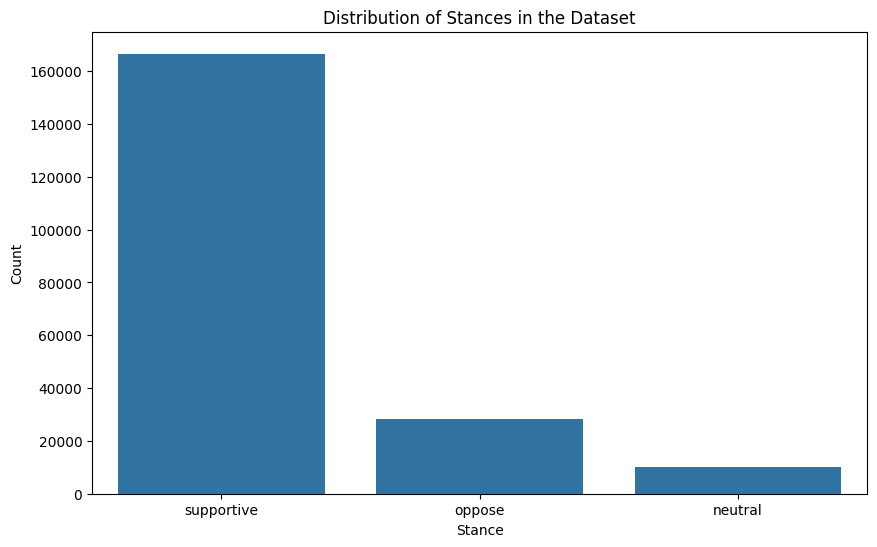

Naive Bayes Results:
Accuracy: 0.8753200516959692
Classification Report:
              precision    recall  f1-score   support

     neutral       0.94      0.06      0.11      2095
      oppose       0.86      0.49      0.62      5566
  supportive       0.88      0.99      0.93     33348

    accuracy                           0.88     41009
   macro avg       0.89      0.51      0.55     41009
weighted avg       0.88      0.88      0.85     41009



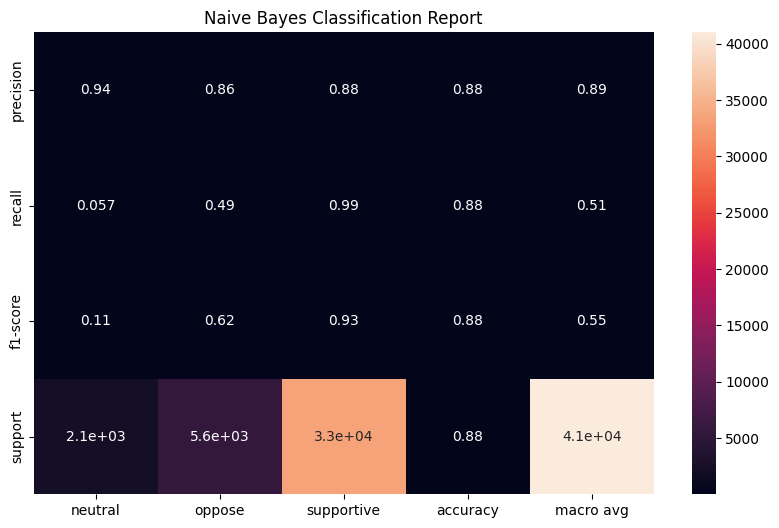

SVM Results:
Accuracy: 0.850618156989929
Classification Report:
              precision    recall  f1-score   support

     neutral       0.31      0.68      0.43      2095
      oppose       0.67      0.76      0.72      5566
  supportive       0.97      0.88      0.92     33348

    accuracy                           0.85     41009
   macro avg       0.65      0.77      0.69     41009
weighted avg       0.90      0.85      0.87     41009



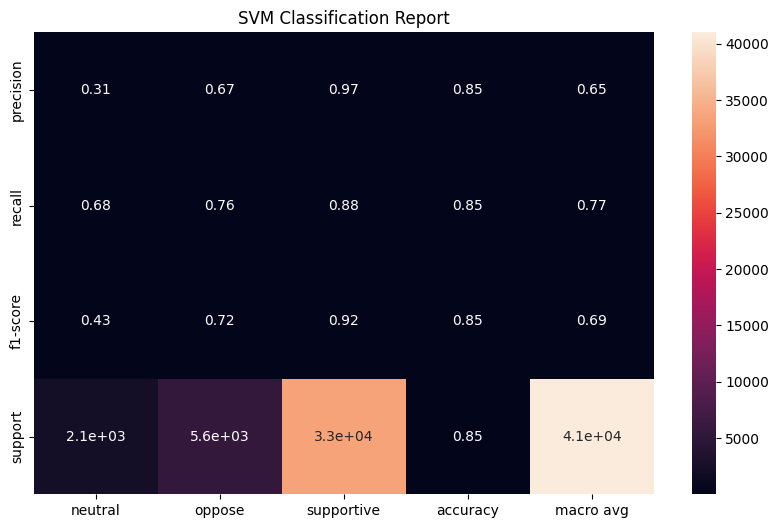

Random Forest Results:
Accuracy: 0.9082884244921846
Classification Report:
              precision    recall  f1-score   support

     neutral       0.55      0.55      0.55      2095
      oppose       0.81      0.72      0.76      5566
  supportive       0.94      0.96      0.95     33348

    accuracy                           0.91     41009
   macro avg       0.77      0.74      0.76     41009
weighted avg       0.91      0.91      0.91     41009



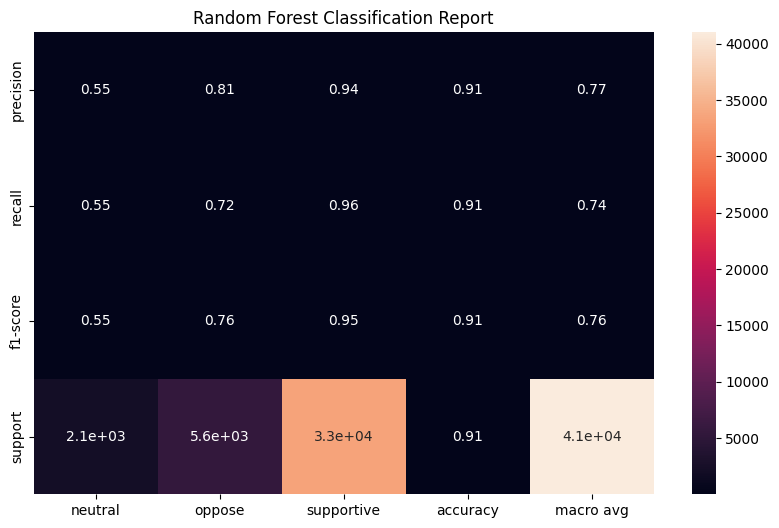

c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2563/2563 - 59s - 23ms/step - accuracy: 0.8813 - loss: 0.4126 - val_accuracy: 0.8659 - val_loss: 0.3654
Epoch 2/5
2563/2563 - 57s - 22ms/step - accuracy: 0.9038 - loss: 0.3256 - val_accuracy: 0.9022 - val_loss: 0.2677
Epoch 3/5
2563/2563 - 57s - 22ms/step - accuracy: 0.9171 - loss: 0.2730 - val_accuracy: 0.8894 - val_loss: 0.3186
Epoch 4/5
2563/2563 - 57s - 22ms/step - accuracy: 0.9298 - loss: 0.2276 - val_accuracy: 0.9187 - val_loss: 0.2332
Epoch 5/5
2563/2563 - 57s - 22ms/step - accuracy: 0.9395 - loss: 0.1997 - val_accuracy: 0.8990 - val_loss: 0.3151
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
CNN Results:
Accuracy: 0.8989733960837865
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.77      0.47      2095
           1       0.90      0.83      0.86      5566
           2       0.99      0.92      0.95     33348

    accuracy                           0.90     41009
   macro avg       0.74      0.84      0.76     41

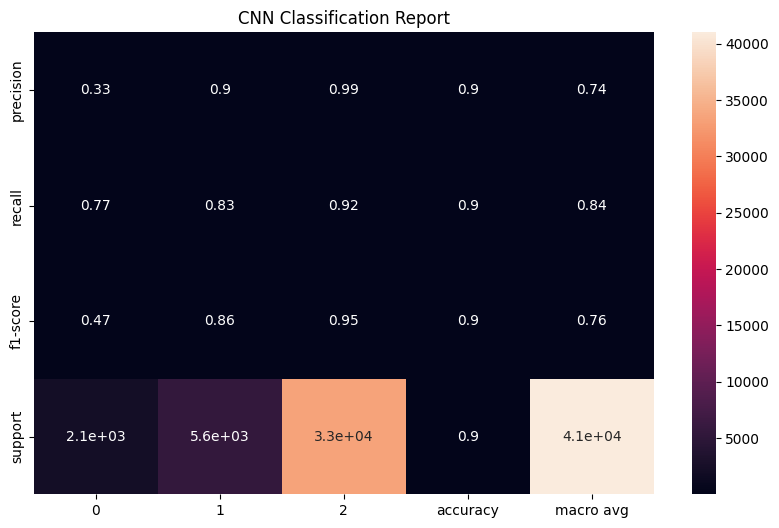

Epoch 1/5


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2563/2563 - 174s - 68ms/step - accuracy: 0.8738 - loss: 0.4572 - val_accuracy: 0.8923 - val_loss: 0.2943
Epoch 2/5
2563/2563 - 172s - 67ms/step - accuracy: 0.8952 - loss: 0.3576 - val_accuracy: 0.8937 - val_loss: 0.2675
Epoch 3/5
2563/2563 - 173s - 67ms/step - accuracy: 0.9007 - loss: 0.3287 - val_accuracy: 0.8959 - val_loss: 0.2688
Epoch 4/5
2563/2563 - 172s - 67ms/step - accuracy: 0.9064 - loss: 0.3080 - val_accuracy: 0.8889 - val_loss: 0.2817
Epoch 5/5
2563/2563 - 170s - 67ms/step - accuracy: 0.9116 - loss: 0.2887 - val_accuracy: 0.9032 - val_loss: 0.2448
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step
LSTM Results:
Accuracy: 0.9031919822477993
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.79      0.48      2095
           1       0.90      0.85      0.87      5566
           2       0.99      0.92      0.95     33348

    accuracy                           0.90     41009
   macro avg       0.74      0.85      0.77     4100

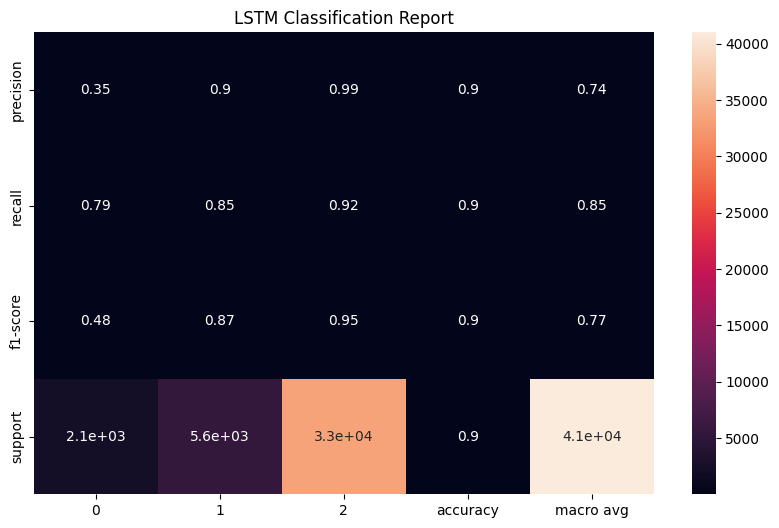

In [1]:
!pip install --user matplotlib seaborn

import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Bidirectional, SpatialDropout1D
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Load data from CSV file
df = pd.read_csv('200kReviewWithSentimentFlipkart.csv')

# Keep only 'Summary' and 'Stance' columns
df = df[['Summary', 'Stance']]

# Drop rows where 'Summary' or 'Stance' is NaN
df = df.dropna(subset=['Summary', 'Stance'])

# Ensure all entries in 'Summary' are strings
df['Summary'] = df['Summary'].astype(str)

# for full review display without truncation
pd.set_option('display.max_colwidth', None)

# Print value counts of 'Stance' column
print(df['Stance'].value_counts())

# Plot the distribution of the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='Stance', data=df)
plt.title('Distribution of Stances in the Dataset')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.show()

# Preprocess the text data
stop_words = list(stopwords.words('english'))
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.7)

# Transform the text data into TF-IDF features
X = tfidf.fit_transform(df['Summary'])

# Encode the target labels
y = df['Stance']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict the stances on the test set using Naive Bayes
nb_y_pred = nb_model.predict(X_test)

# Evaluate the Naive Bayes model
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred, output_dict=True)
print("Naive Bayes Results:")
print(f"Accuracy: {nb_accuracy}")
print("Classification Report:")
print(classification_report(y_test, nb_y_pred))

# Plot Naive Bayes classification report
nb_report_df = pd.DataFrame(nb_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(nb_report_df.iloc[:-1, :].T, annot=True)
plt.title('Naive Bayes Classification Report')
plt.show()

# Initialize and train the SVM classifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

svm_model = SVC(kernel='linear', class_weight=class_weights_dict)
svm_model.fit(X_train, y_train_encoded)

# Predict the stances on the test set using SVM
svm_y_pred_encoded = svm_model.predict(X_test)
svm_y_pred = label_encoder.inverse_transform(svm_y_pred_encoded)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)
print("SVM Results:")
print(f"Accuracy: {svm_accuracy}")
print("Classification Report:")
print(classification_report(y_test, svm_y_pred))

# Plot SVM classification report
svm_report_df = pd.DataFrame(svm_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(svm_report_df.iloc[:-1, :].T, annot=True)
plt.title('SVM Classification Report')
plt.show()

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train_encoded)

# Predict the stances on the test set using Random Forest
rf_y_pred_encoded = rf_model.predict(X_test)
rf_y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy}")
print("Classification Report:")
print(classification_report(y_test, rf_y_pred))

# Plot Random Forest classification report
rf_report_df = pd.DataFrame(rf_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(rf_report_df.iloc[:-1, :].T, annot=True)
plt.title('Random Forest Classification Report')
plt.show()

# Tokenizer and padding for deep learning models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Summary'])
X_seq = tokenizer.texts_to_sequences(df['Summary'])
X_pad = pad_sequences(X_seq, maxlen=100)
y_encoded = pd.get_dummies(df['Stance']).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

# Compute class weights for deep learning models
class_weights_dl = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dl_dict = {i: weight for i, weight in enumerate(class_weights_dl)}

# CNN Model
cnn_model = Sequential()
cnn_model.add(Embedding(5000, 128, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dl_dict, verbose=2)

cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred_labels = cnn_y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

cnn_accuracy = accuracy_score(y_test_labels, cnn_y_pred_labels)
cnn_report = classification_report(y_test_labels, cnn_y_pred_labels, output_dict=True)
print("CNN Results:")
print(f"Accuracy: {cnn_accuracy}")
print("Classification Report:")
print(classification_report(y_test_labels, cnn_y_pred_labels))

# Plot CNN classification report
cnn_report_df = pd.DataFrame(cnn_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(cnn_report_df.iloc[:-1, :].T, annot=True)
plt.title('CNN Classification Report')
plt.show()

# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(5000, 128, input_length=100))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dl_dict, verbose=2)

lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_labels = lstm_y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

lstm_accuracy = accuracy_score(y_test_labels, lstm_y_pred_labels)
lstm_report = classification_report(y_test_labels, lstm_y_pred_labels, output_dict=True)
print("LSTM Results:")
print(f"Accuracy: {lstm_accuracy}")
print("Classification Report:")
print(classification_report(y_test_labels, lstm_y_pred_labels))

# Plot LSTM classification report
lstm_report_df = pd.DataFrame(lstm_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(lstm_report_df.iloc[:-1, :].T, annot=True)
plt.title('LSTM Classification Report')
plt.show()
